In [136]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp


def generate_trainingdata(m):
    return np.array([0,0])+0.25*np.random.randn(m,2)

def f(x, minibatch):
    # loss function sum_{w in training data} f(x,w)
    y=0; count=0
    for w in minibatch:

        z=x-w-1
        y=y+sp.Min(40*(z[0]**2+z[1]**2), (z[0]+5)**2+(z[1]+2)**2)   
        count=count+1
    return y/count

In [2]:
class F1:
    def f1(self , x, minibatch):
        # loss function sum_{w in training data} f(x,w)
       
        y=0; count=0
        for w in minibatch:
            z=x-w-1
            y=y+sp.Min(40*(z[0]**2+z[1]**2), (z[0]+5)**2+(z[1]+2)**2)   
            count=count+1
        return y/count
    
    def f2(self, x, minibatch):
        # loss function sum_{w in training data} f(x,w)
        y=0; count=0
        for w in minibatch:
            z=x-w-1
            y=y+np.minimum(40*(z[0]**2+z[1]**2), (z[0]+5)**2+(z[1]+2)**2)   
            count=count+1
        return y/count  
    
    def dfdx(self, xy, minibatch):
        
        x = sp.symbols('x')
        y = sp.symbols('y')
        f4 = self.f1([x,y], minibatch)
        dfdx = sp.diff(f4, x)
        dfdx = dfdx.evalf(subs={x: xy[0], y: xy[1]})
        return dfdx



    def dfdy(self, xy, minibatch):
        
        x = sp.symbols('x') 
        y = sp.symbols('y')
        f4 = self.f1([x,y], minibatch)
        dfdy = sp.diff(f4, y)
        dfdy = dfdy.evalf(subs={x: xy[0], y: xy[1]})
        return dfdy   
    
    def dfdx_aprox(self, xy, minibatch, h=0.0000001):
        fminus = self.f2([xy[0]-h,xy[1]], minibatch) 
        fplus = self.f2([xy[0]+h,xy[1]], minibatch)
        dfdx = (fplus-fminus)/(2*h)
        return dfdx
    
    def dfdy_aprox(self, xy, minibatch, h=0.0000001):
        fminus = self.f2([xy[0],xy[1]-h], minibatch) 
        fplus = self.f2([xy[0],xy[1]+h], minibatch)
        dfdy = (fplus-fminus)/(2*h)
        return dfdy

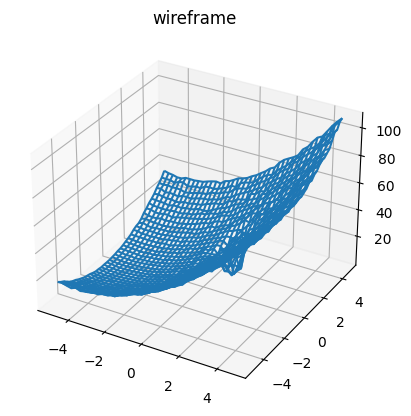

In [3]:
#plot wireframe and contour plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(-5, 5, 0.25)
y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(x, y)
zs = np.array([f([x,y], generate_trainingdata()) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
ax.plot_wireframe(X, Y, Z)
ax.set_title('f(x,N)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()


In [111]:
def gradDescent_2d(fn,start,alpha,num_iters, minibatch):
    
    x0 = start
    X=np.array([x0[0]]); 
    Y=np.array([x0[1]]);
    F_xy=np.array([fn.f2(x0, minibatch)]);

    for k in range(num_iters):
        x0 = x0 - alpha*np.array([fn.dfdx_aprox(x0, minibatch), fn.dfdy_aprox(x0, minibatch)])
        X=np.append(X,x0[0]); 
        Y=np.append(Y,x0[1]);
        F_xy=np.append(F_xy,fn.f2(x0, minibatch));
    return (X,Y, F_xy)


In [253]:
def SDG (fn, x0, trainingdata, alpha, epoch, batch_size):

    # x0 is the initial point
    x = x0

    # store the x, y, f(x,y) for plotting
    X=np.array([x0[0]])
    Y=np.array([x0[1]])
    F_xy=np.array(fn.f2(x0, trainingdata))

    
    for i in range(epoch):
        #shuffle the minibatch
        np.random.shuffle(trainingdata)

        #split the minibatch
        for m in range(0,len(trainingdata), batch_size):
            minibatch=trainingdata[m:m+batch_size]
            # using sypmify to calculate the gradient
            # x = x - alpha * np.array([fn.dfdx(x, minibatch), fn.dfdy(x, minibatch)])
            # using finite difference to calculate the gradient
            x = x - alpha * np.array([fn.dfdx_aprox(x, minibatch), fn.dfdy_aprox(x, minibatch)])

        # store the x, y, f(x,y) for plotting per epoch
        X=np.append(X,x[0])
        Y=np.append(Y,x[1])
        F_xy=np.append(F_xy,fn.f2(x, minibatch))
    return  X, Y, F_xy

In [310]:
def SGD_Polyak(fn, x0, trainingdata, fs, num_iter,reg, batch_size):
    # starting point
    x = x0
    y = x0
    # initialize the sum of gradient
    X=np.array([x0[0]])
    Y=np.array([x0[1]])
    F_xy=np.array(fn.f2(x0, trainingdata))
    sum_x = 0;
    n_x = 0
    
    for i in range(num_iter):
        #suffle the minibatch
        np.random.shuffle(trainingdata)
        for m in range(0,len(trainingdata), batch_size):
            minibatch = trainingdata[m:m+batch_size]
       
            sum_x += np.array([fn.dfdx_aprox(x, minibatch), fn.dfdy_aprox(x, minibatch)])**2
            n_x = (fn.f2(x, minibatch) + fs)/((sum_x) +reg)

            x = x - n_x * np.array([fn.dfdx_aprox(x, minibatch), fn.dfdy_aprox(x, minibatch)])


        X=np.append(X,[x],axis=0); # x      
        Y=np.append(Y,[y],axis=0); # y
        F_xy=np.append(F_xy,[fn.f(x, y)]); # f(x,y)
    return  X, Y, F_xy

In [323]:
def SGD_RMSProp(fn, x0, trainingdata, alpha, num_iter,reg, beta, batch_size): 
    x = x0
    y = x0
    X=np.array([x0[0]])
    Y=np.array([x0[1]])
    F_xy=np.array(fn.f2(x0, trainingdata))
    sum_x = 0;sum_y = 0
    alpha_x = alpha; alpha_y = alpha
    
    for i in range(num_iter):
        #suffle the minibatch
        np.random.shuffle(trainingdata)
        for m in range(0,len(trainingdata), batch_size):
            minibatch = trainingdata[m:m+batch_size]
            step_x = fn.dfdx_aprox((x,y), minibatch)
            step_y = fn.dfdy_aprox((x,y), minibatch)

            #update x and y 
            x = x - alpha_x * step_x
            y = y - alpha_y * step_y

            #update sum_x and sum_y
            sum_x = beta * sum_x + (1-beta) * (fn.dfdx_aprox((x,y), minibatch)**2)
            sum_y = beta * sum_y + (1-beta) * (fn.dfdy_aprox((x,y), minibatch)**2)
            
            #update alpha_x and alpha_y
            alpha_x = alpha_x/(np.sqrt(float(sum_x))+reg)
            alpha_y = alpha_y/(np.sqrt(float(sum_y))+reg)

        X=np.append(X,[x],axis=0); # x      
        Y=np.append(Y,[y],axis=0); # y
        F_xy=np.append(F_xy,[fn.f(x, y)]); # f(x,y)
    return  X, Y, F_xy

In [338]:
def SDG_heavy_ball(fn, x0, trainingdata, alpha, num_iter,reg, beta, batch_size): 
    x = x0[0]
    y = x0[1]
    X=np.array([x])
    Y=np.array([y])
    F_xy=np.array(fn.f2((x,y), trainingdata))
    z=0;  j=0
    alpha_x = alpha; alpha_y = alpha
    
    for i in range(num_iter):
        #suffle the minibatch
        np.random.shuffle(trainingdata)
        for m in range(0,len(trainingdata), batch_size):
            minibatch = trainingdata[m:m+batch_size]
            step_x = fn.dfdx_aprox((x,y), minibatch)
            step_y = fn.dfdy_aprox((x,y), minibatch)

            #update z and j 
            z = beta*z - alpha_x * step_x
            j = beta*j - alpha_y * step_y

            x = x + z
            y = y + j


        X=np.append(X,[x],axis=0); # x      
        Y=np.append(Y,[y],axis=0); # y
        F_xy=np.append(F_xy,fn.f2((x,y), minibatch))
    return  X, Y, F_xy

In [413]:
def SGD_Adam(fn,start, trainingdata, alpha,epoch, reg, beta1, beta2, batch_size):
    x = start
    y = start
    X=np.array([x])
    Y=np.array([y])
    F_xy=np.array(fn.f2((x,y), trainingdata))
    #running average of the gradient
    m_x = 0; m_y = 0
    #running average of the squared gradient
    v_x = 0; v_y = 0
    #bias correction
    m_x_hat = 0; m_y_hat = 0
    alpha_x = alpha; alpha_y = alpha
    for i in range(epoch):
        #suffle the minibatch
        np.random.shuffle(trainingdata)
        for m in range(0,len(trainingdata), batch_size):
            minibatch = trainingdata[m:m+batch_size]
            step_x = fn.dfdx_aprox((x,y), minibatch)
            step_y = fn.dfdy_aprox((x,y), minibatch)

            #update m_x and m_y
            m_x = beta1 * m_x + (1-beta1) * step_x
            m_y = beta1 * m_y + (1-beta1) * step_y

            #update v_x and v_y
            v_x = beta2 * v_x + (1-beta2) * (step_x**2)
            v_y = beta2 * v_y + (1-beta2) * (step_y**2)

            #update m_x_hat and m_y_hat
            m_x_hat = m_x/(1-beta1**(m+1))
            m_y_hat = m_y/(1-beta1**(m+1))

            #update v_x_hat and v_y_hat
            v_x_hat = v_x/(1-beta2**(m+1))
            v_y_hat = v_y/(1-beta2**(m+1))
            
            #update x and y
            x = x - alpha_x * m_x_hat/(np.sqrt(float(v_x_hat[0]))+reg)
            y = y - alpha_y * m_y_hat/(np.sqrt(float(v_y_hat[1]))+reg)

        X = np.append(X, [x])
        Y=np.append(Y,[y])
        F_xy=np.append(F_xy,fn.f2((x,y), minibatch))
    return  X, Y, F_xy



In [147]:
# call sgd function

X_list=[]; Y_list=[]; F_XY=[]
X_list1=[]; Y_list1=[]; F_XY1=[]
X_list2=[]; Y_list2=[]; F_XY2=[]
X_list3=[]; Y_list3=[]; F_XY3=[]
X_list4=[]; Y_list4=[]; F_XY4=[]
X_list5=[]; Y_list5=[]; F_XY5=[]


F_XY = []
epoch = 10
fn = F1()
alpha = 0.1
reg = 0.0001
batch_size = 5

minibatch = generate_trainingdata(25)
X_list,Y_list, F_XY = SDG(fn, np.array([3,3]), minibatch, alpha, epoch,  batch_size )
# X_list1,Y_list1, F_XY1 = SGD_Polyak(fn, np.array([2,2]), minibatch, np.array([0,0]), epoch, reg, batch_size)
# X_list2,Y_list2, F_XY2 = SDG_RMSProp(fn, np.array([2,2]), minibatch, alpha, epoch, reg, 0.9, batch_size)
# X_list3,Y_list3, F_XY3 = SDG_heavy_ball(fn, np.array([2,2]), minibatch, 0.1, epoch, reg, 0.9, batch_size)
# X_list4,Y_list4, F_XY4 = SDG_Adam(fn, np.array([-2,-4]), minibatch, 0.9, epoch, reg, 0.9, 0.99, batch_size)
X_list5, Y_list5, F_XY5 = gradDescent_2d(fn, np.array([3,3]), alpha, epoch, minibatch )


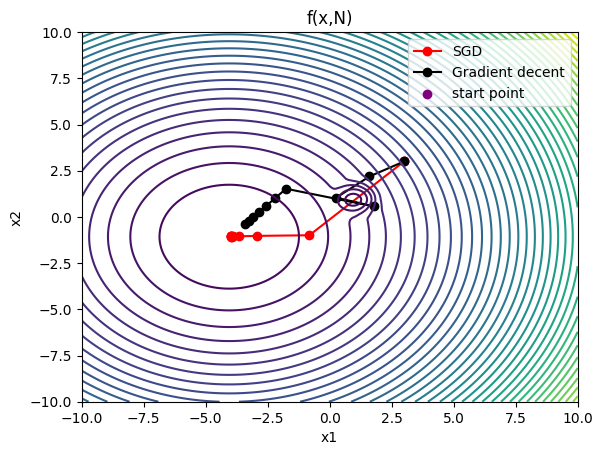

In [148]:
#plot the result
plt.plot(X_list,Y_list, label = "SGD", color = "red", marker = "o")
# plt.plot(X_list1,Y_list1, label = "SGD_Polyak", color = "blue", marker = "o")
# # plt.plot(X_list2,Y_list2, label = "SGD_RMSProp", color = "green", marker = "o")
# # plt.plot(X_list3,Y_list3, label = "SGD_heavy_ball", color = "yellow", marker = "o")
# plt.plot(X_list4,Y_list4, label = "SGD_Adam", color = "black", marker = "o")
plt.plot(X_list5,Y_list5, label = "Gradient decent", color = "black", marker = "o")#

#plot start point 
plt.scatter(3,3, label = "start point", color = "purple", marker = "o")


plt.legend()

x = np.linspace(-10,10,200)
y = np.linspace(-10,10,200)



X, Y = np.meshgrid(x, y)
m = 25
XX = generate_trainingdata(m)
fn = F1()
Z = np.array([fn.f2(np.array([x,y]),XX) for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = Z.reshape(X.shape)
plt.title('f(x,N)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.contour(X, Y, Z, 50)
plt.show()



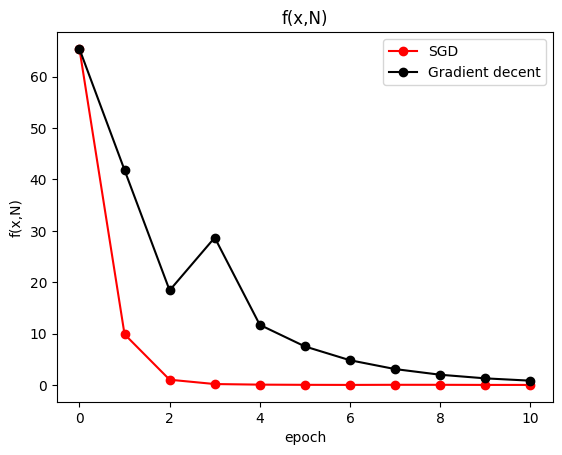

In [149]:
#plot f value vs epoch
plt.plot(F_XY, label = "SGD", color = "red", marker = "o")
# plt.plot(F_XY1, label = "SGD_Polyak", color = "blue", marker = "o")
# plt.plot(F_XY2, label = "SGD_RMSProp", color = "green", marker = "o")
# plt.plot(F_XY3, label = "SGD_heavy_ball", color = "yellow", marker = "o")
# plt.plot(F_XY4, label = "SGD_Adam", color = "black", marker = "o")
plt.plot(F_XY5, label = "Gradient decent", color = "black", marker = "o")
plt.legend()
plt.title('f(x,N)')
plt.xlabel('epoch')
plt.ylabel('f(x,N)')
plt.show()


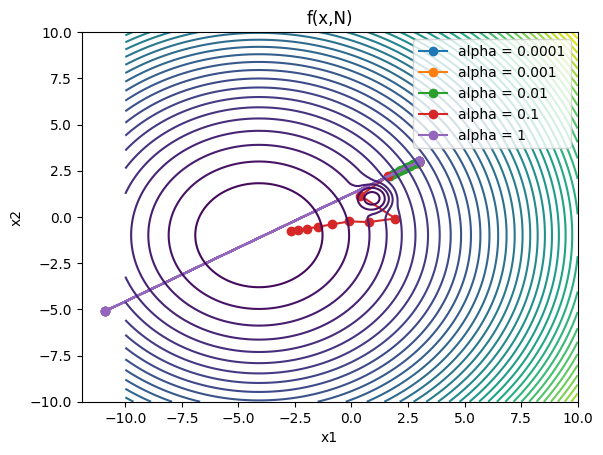

In [120]:
alpha_range = [0.0001, 0.001, 0.01, 0.1, 1]	

X_list = []
Y_list = []
F_XY_list = []
epoch = 10
fn = F1()
reg = 0.0001
batch_size = 5
m  = 25
minibatch = generate_trainingdata(m)


for alpha in alpha_range:
    X, Y, F_XY = gradDescent_2d(fn, np.array([3,3]), alpha, epoch, minibatch )
    #append the result to the list
    X_list.append(X)
    Y_list.append(Y)
    F_XY_list.append(F_XY)

#plot the result
for i in range(len(alpha_range)):
    plt.plot(X_list[i],Y_list[i], label = "alpha = " + str(alpha_range[i]), marker = "o")

plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()

#contour plot
x = np.linspace(-10,10,200)
y = np.linspace(-10,10,200)
X, Y = np.meshgrid(x, y)
XX = generate_trainingdata(m)
fn = F1()
Z = np.array([fn.f2(np.array([x,y]),XX) for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = Z.reshape(X.shape)
plt.title('f(x,N)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.contour(X, Y, Z, 50)
plt.show()






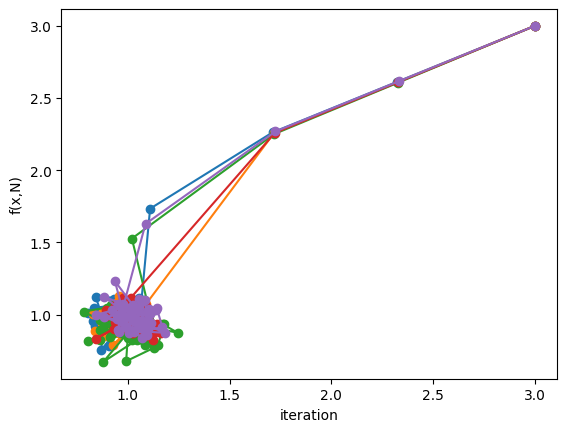

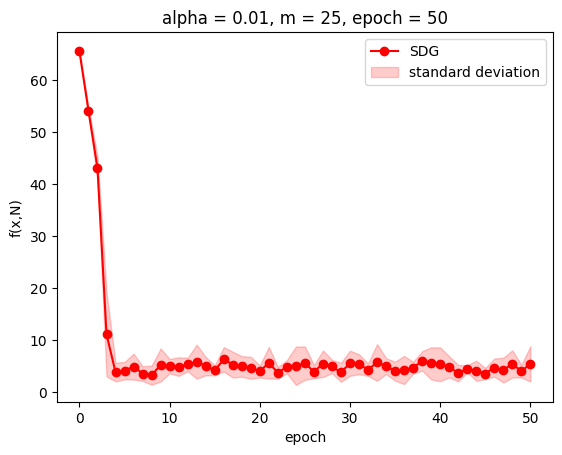

In [98]:

X_list = []
Y_list = []
F_XY_list = []
epoch = 50
fn = F1()
reg = 0.0001
batch_size = 5
m = 25
minibatch = generate_trainingdata(m)
alpha = 0.01
for i in  range(5):
    X,Y, F_XY = SDG(fn, np.array([3,3]), generate_trainingdata(m), alpha, epoch,  batch_size )
    #append the result to the list
    X_list.append(X)
    Y_list.append(Y)
    F_XY_list.append(F_XY)

#plot for different runs 
for i in range(5):
    # plt.plot(F_XY_list[i], label = "SDG", color = "red", marker = "o")
    plt.plot(X_list[i], Y_list[i], label = "SDG", marker = "o")

plt.xlabel('iteration')
plt.ylabel('f(x,N)')

plt.show()

F_XY_ave = np.mean(F_XY_list, axis = 0)
#standard deviation
var_1 = np.std(F_XY_list, axis = 0)




#plot the result with standard deviation
plt.plot(F_XY_ave, label = "SDG", color = "red", marker = "o")
plt.fill_between(range(len(F_XY_ave)), F_XY_ave-var_1, F_XY_ave+var_1, color = "red", alpha = 0.2, label = "standard deviation")
plt.title('alpha = 0.01, m = 25, epoch = 50')
plt.xlabel('epoch')
plt.ylabel('f(x,N)')
plt.legend()	
plt.show()






   

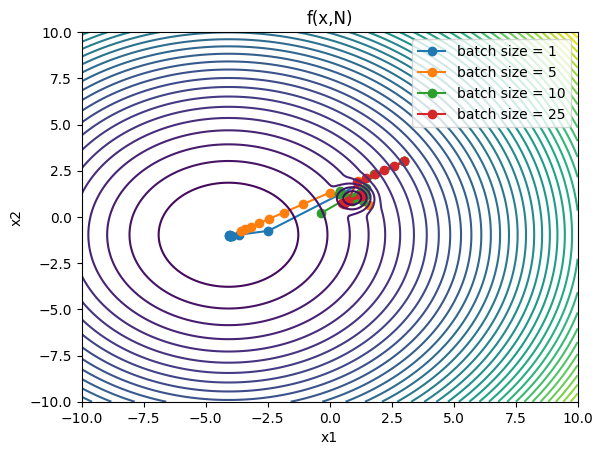

In [143]:
#now we try to plot the result for different batch size

X_list = []
Y_list = []
F_XY_list = []
epoch = 10
fn = F1()
reg = 0.0001
m_range = [1, 5, 10, 25]
trainingdata = generate_trainingdata(25)
alpha = 0.03
batch_size = 5
for k in m_range:
    X,Y, F_XY = SDG(fn, np.array([3,3]), trainingdata, alpha, epoch,  k )
    #append the result to the list
    X_list.append(X)
    Y_list.append(Y)
    F_XY_list.append(F_XY)

#plot for different batch size
for i in range(len(m_range)):
    plt.plot(X_list[i], Y_list[i], marker = "o", label = "batch size = {}".format(m_range[i]))
    # plt.plot(X_list[i], Y_list[i], label = "SDG", marker = "o")


plt.legend()
#contour plot
x = np.linspace(-10,10,200)
y = np.linspace(-10,10,200)
X, Y = np.meshgrid(x, y)
XX = generate_trainingdata(m)
fn = F1()
Z = np.array([fn.f2(np.array([x,y]),XX) for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = Z.reshape(X.shape)
plt.title('f(x,N)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.contour(X, Y, Z, 50)
plt.show()



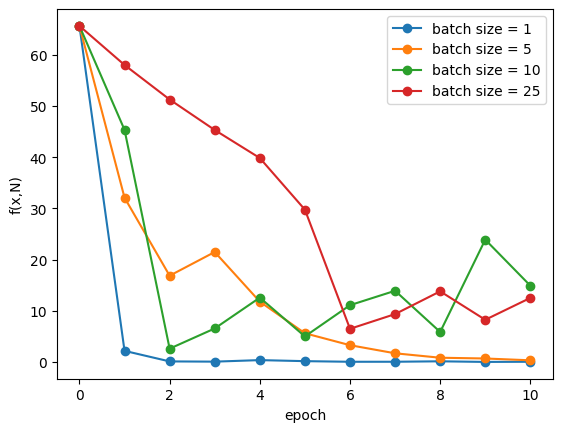

In [144]:
#plot for different batch size vs time 
for i in range(len(m_range)):
    plt.plot(F_XY_list[i], label = "batch size = {}".format(m_range[i]), marker = "o")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('f(x,N)')
plt.show()


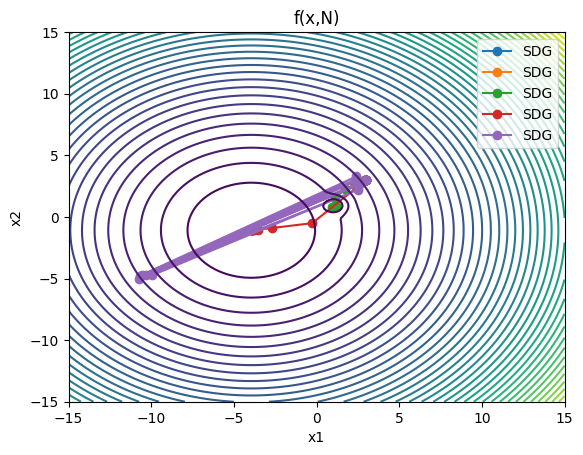

In [154]:
#now batch size = 5 we vary the learning rate

alpha_range = [0.0001, 0.001, 0.01, 0.1, 1]
X_list = []
Y_list = []
F_XY_list = []
epoch = 10
fn = F1()
reg = 0.0001
m = 25
trainingdata = generate_trainingdata(m)
batch_size = 5
for alpha in alpha_range:
    X,Y, F_XY = SDG(fn, np.array([3,3]), trainingdata, alpha, epoch,  batch_size )
    #append the result to the list
    X_list.append(X)
    Y_list.append(Y)
    F_XY_list.append(F_XY)

#plot for different batch size
for i in range(len(alpha_range)):
    #plt.plot(F_XY_list[i],  marker = "o", label = "alpha = {}".format(alpha_range[i]))
    plt.plot(X_list[i], Y_list[i], label = "SDG", marker = "o")

plt.legend()
# plt.xlabel('epoch')
# plt.ylabel('f(x,N)')
# plt.show()


#contour plot
x = np.linspace(-15,15,200)
y = np.linspace(-15,15,200)
X, Y = np.meshgrid(x, y)
XX = generate_trainingdata(m)
fn = F1()
Z = np.array([fn.f2(np.array([x,y]),XX) for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = Z.reshape(X.shape)
plt.title('f(x,N)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.contour(X, Y, Z, 50)
plt.show()



In [ ]:
#otimise loss function with 
#plot the result
X_list,Y_list, F_XY = SDG(fn, np.array([3,3]), minibatch, alpha, epoch,  batch_size )
# X_list1,Y_list1, F_XY1 = SGD_Polyak(fn, np.array([2,2]), minibatch, np.array([0,0]), epoch, reg, batch_size)
# X_list2,Y_list2, F_XY2 = SDG_RMSProp(fn, np.array([2,2]), minibatch, alpha, epoch, reg, 0.9, batch_size)
# X_list3,Y_list3, F_XY3 = SDG_heavy_ball(fn, np.array([2,2]), minibatch, 0.1, epoch, reg, 0.9, batch_size)
# X_list4,Y_list4, F_XY4 = SDG_Adam(fn, np.array([-2,-4]), minibatch, 0.9, epoch, reg, 0.9, 0.99, batch_size)
X_list5, Y_list5, F_XY5 = gradDescent_2d(fn, np.array([3,3]), alpha, epoch, minibatch )

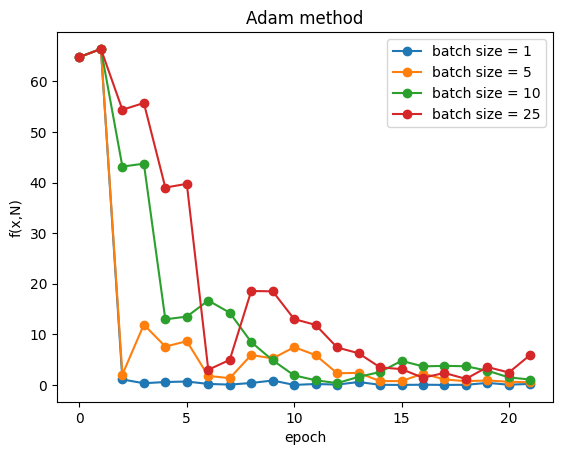

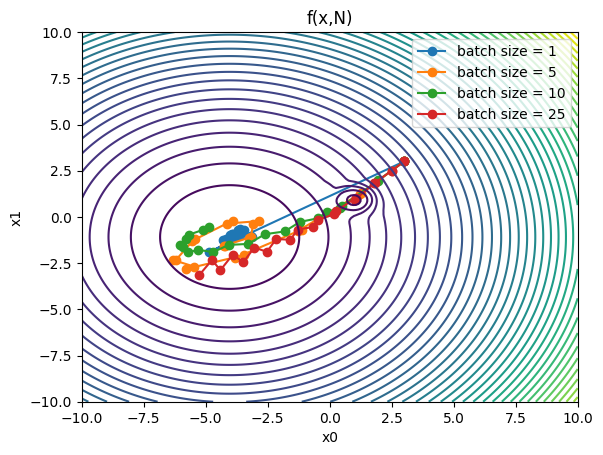

In [420]:
#optimalize loss fucntion with SGD_Polyak

X_list1 = []; Y_list1 = []; F_XY_list1 = []
X_list2 = []; Y_list2 = []; F_XY_list2 = []
X_list3 = []; Y_list3 = []; F_XY_list3 = []
X_list4 = []; Y_list4 = []; F_XY_list4 = []


epoch = 10
fn = F1()
reg = 0.000001
m = 25
trainingdata = generate_trainingdata(m)
batch_range = [1, 5, 10, 25	 ]
alpha = 0.1
beta1 = 0.9
beta2 = 0.9


for batch_size in batch_range:
    X,Y, F_XY = SGD_Adam(fn, np.array([3,3]), minibatch, 0.5, epoch, reg, 0.9, 0.9, batch_size)
    
   
    X_list4.append(X)
    Y_list4.append(Y)
    F_XY_list4.append(F_XY)
   

#plot for different batch size
for i in range(len(batch_range)):
   plt.plot(F_XY_list4[i],  marker = "o", label = "batch size = {}".format(batch_range[i]))
   #plt.plot(X_list4[i], Y_list4[i],label = "batch size = {}".format(batch_range[i]), marker = "o")


plt.title('Adam method')
plt.xlabel('epoch')
plt.ylabel('f(x,N)')
plt.legend()
plt.show()

for i in range(len(batch_range)):
   #plt.plot(F_XY_list4[i],  marker = "o", label = "batch size = {}".format(batch_range[i]))
   plt.plot(X_list4[i], Y_list4[i],label = "batch size = {}".format(batch_range[i]), marker = "o")


plt.legend()
# plt.show()



# countour plot
x = np.linspace(-10,10,200)
y = np.linspace(-10,10,200)
X, Y = np.meshgrid(x, y)
XX = generate_trainingdata(m)
fn = F1()
Z = np.array([fn.f2(np.array([x,y]),XX) for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = Z.reshape(X.shape)
plt.title('f(x,N)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.contour(X, Y, Z, 50)
plt.show()



4


In [296]:

X_list1 = []; Y_list1 = []; F_XY_list1 = []
X_list2 = []; Y_list2 = []; F_XY_list2 = []

epoch = 10
fn = F1()
reg = 0.0001
m = 25
trainingdata = generate_trainingdata(m)
batch_range = [1, 5, 10, 25]
alpha = 0.3

#otimise loss function with 
#plot the result
X_list,Y_list, F_XY = SDG(fn, np.array([3,3]), trainingdata, 0.1, epoch,  5 )
# X_list1,Y_list1, F_XY1 = SGD_Polyak(fn, np.array([3,3]), trainingdata, np.array([2,2]), epoch, reg, 5)
#X_list2,Y_list2, F_XY2 = SGD_RMSProp(fn, np.array([2,2]), trainingdata, alpha, epoch, reg, 0.9, batch_size)
X_list3,Y_list3, F_XY3 = SDG_heavy_ball(fn, np.array([2,2]), trainingdata, 0.1, epoch, reg, 0.9, batch_size)
X_list4,Y_list4, F_XY4 = SGD_Adam(fn, np.array([-2,-4]), trainingdata, 0.9, epoch, reg, 0.9, 0.99, batch_size)
#X_list5, Y_list5, F_XY5 = gradDescent_2d(fn, np.array([3,3]), alpha, epoch, minibatch )


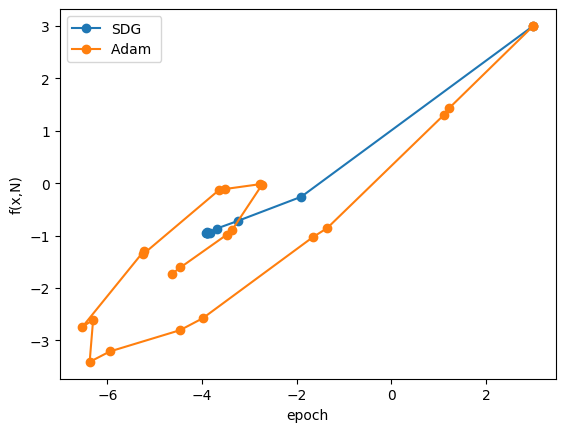

In [422]:
#plot for RMS vs SDG
X_list1 = []; Y_list1 = []; F_XY_list1 = []
X_list2 = []; Y_list2 = []; F_XY_list2 = []


epoch = 10
fn = F1()
reg = 0.0001
m = 25
trainingdata = generate_trainingdata(m)
batch_range = [1, 5, 10, 25]
alpha = 0.9

#otimise loss function with 
#plot the result
X_list,Y_list, F_XY = SDG(fn, np.array([3,3]), trainingdata, 0.1, epoch,  5 )

X_list3,Y_list3, F_XY3 = SGD_Adam(fn, np.array([3,3]), minibatch, 0.5, epoch, reg, 0.9, 0.9, 5)


fig = plt.figure()
plt.plot(X_list, Y_list, label = "SDG", marker = "o" )
plt.plot(X_list3, Y_list3, label = "Adam ", marker = "o" )
plt.legend()
plt.ylabel('f(x,N)')
plt.xlabel('epoch')
plt.show()

# #mesh plot
# x = np.linspace(-10,10,200)
# y = np.linspace(-10,10,200)
# X, Y = np.meshgrid(x, y)
# XX = generate_trainingdata(m)
# fn = F1()
# Z = np.array([fn.f2(np.array([x,y]),XX) for x,y in zip(np.ravel(X), np.ravel(Y))])

# Z = Z.reshape(X.shape)
# plt.title('f(x,N)')
# plt.xlabel('x0')
# plt.ylabel('x1')
# plt.contour(X, Y, Z, 50)
# plt.show()





